# Yelp Dataset

This dataset is a small portion of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the dataset you'll find information about businesses across 11 metropolitan areas in two countries.

More information can be found at [Yelp](https://www.yelp.com/dataset/documentation/main).  
Some dataset examples can be found on their [GitHub](https://github.com/Yelp/dataset-examples) page.

Currently, the metropolitan areas centered on Montreal, Calgary, Toronto, Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison, and Cleveland, are included in the dataset.  

Summary for contents of each JSON file:  

**business.json**  
Contains business data including location data, attributes, and categories

**review.json**  
Contains full review text data including the user_id that wrote the review and the business_id the review is written for.

**user.json**  
User data including the user's friend mapping and all the metadata associated with the user.

**checkin.json**  
Checkins on a business.

**tip.json**  
Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

**photo.json**  
Contains photo data including the caption and classification (one of "food", "drink", "menu", "inside" or "outside").


# MongoDB 

This notebook is using the Yelp Dataset from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) which is first being downloaded as JSON files and then being inserted into a MongoDB database on my local hard drive. This step could be skipped and the json files can be analysed directly using

```pandas.read_json(JSON_file, lines=True, nrows=int)``` since these files are large is it recommended to use nrows.

This is a great chance to upload these files into MongoDB since it uses JSON-like documents.  

Below is a shortened list of SQL to MongoDB Mapping chart from the offical [docs](https://docs.mongodb.com/manual/reference/sql-comparison/)  

| SQL Terms/Concepts|MongoDB Terms/Concepts|
|:----------:|:-------------:|
| database |  database |
| table |    collection   |
| row | document or BSON object |
| column | filed |
| index | index |
| table joins | $lookup |

We start by import libraries and then setting up MongoDB database below using [pymongo](https://pymongo.readthedocs.io/en/stable/) driver

# Import Libraries

In [1]:
import json
import math
from pymongo import MongoClient, ASCENDING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# JSON data
Download data from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) and read JSON files into memory using json library.

In [2]:
data_path0 = 'yelp-data/yelp_academic_dataset_business.json'
data_path1 = 'yelp-data/yelp_academic_dataset_checkin.json'
data_path2 = 'yelp-data/yelp_academic_dataset_review.json'
data_path3 = 'yelp-data/yelp_academic_dataset_tip.json'
data_path4 = 'yelp-data/yelp_academic_dataset_user.json'

In [3]:
data_paths = [data_path0, data_path1, data_path2, data_path3, data_path4]
json_data = [[],[],[],[],[]]

for i, file in enumerate(data_paths,0):
    with open(file) as f:
        for line in f:
            json_data[i].append(json.loads(line))

In [43]:
#pd.read_json(data_path0, lines=True, nrows=5)

# MongoDB

## Creating Collections and inserting documents

Create Yelp Database below, insert new collection called business and using `insert_many()` method the `json_data[0]` above is inserted into this collection.

In [33]:
client = MongoClient('mongodb://localhost:27017/')
db = client['Yelp']
business = db['business']
business.insert_many(json_data[0])

In [34]:
business.find_one()

{'_id': ObjectId('5f73c43926a5b6392883c222'),
 'business_id': 'f9NumwFMBDn751xgFiRbNA',
 'name': 'The Range At Lake Norman',
 'address': '10913 Bailey Rd',
 'city': 'Cornelius',
 'state': 'NC',
 'postal_code': '28031',
 'latitude': 35.4627242,
 'longitude': -80.8526119,
 'stars': 3.5,
 'review_count': 36,
 'is_open': 1,
 'attributes': {'BusinessAcceptsCreditCards': 'True',
  'BikeParking': 'True',
  'GoodForKids': 'False',
  'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  'ByAppointmentOnly': 'False',
  'RestaurantsPriceRange2': '3'},
 'categories': 'Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping',
 'hours': {'Monday': '10:0-18:0',
  'Tuesday': '11:0-20:0',
  'Wednesday': '10:0-18:0',
  'Thursday': '11:0-20:0',
  'Friday': '11:0-20:0',
  'Saturday': '11:0-20:0',
  'Sunday': '13:0-18:0'}}

---

Repeat creating collections with other JSON data

In the end there will be 5 collections.

In [35]:
checkin = db['checkin']
checkin.insert_many(json_data[1])

In [36]:
checkin.find_one()

{'_id': ObjectId('5f73c97226a5b6392886f413'),
 'business_id': '--1UhMGODdWsrMastO9DZw',
 'date': '2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016-10-15 02:45:18, 2016-11-18 01:54:50, 2017-04-20 18:39:06, 2017-05-03 17:58:02, 2019-03-19 22:04:48'}

---

The review JSON file is 6.33 GBs in size and the `insert_many()` function will not be good approach due to memory limitations and looping through the data and inserting batches will be better.

In [49]:
review = db['review']

In [95]:
batches = 100 #number of batches
batch_length = math.ceil(len(json_data[2])/batches) #number of items in each batch
tmp_ = 0 #keep track for number of items in a batch

for i in range(batches):
    data = json_data[2][tmp_:tmp_+batch_length]
    review.insert_many(data)
    tmp_ += batch_length

review.find_one()

{'_id': ObjectId('5f73c9a626a5b6392889a066'),
 'review_id': 'xQY8N_XvtGbearJ5X4QryQ',
 'user_id': 'OwjRMXRC0KyPrIlcjaXeFQ',
 'business_id': '-MhfebM0QIsKt87iDN-FNw',
 'stars': 2.0,
 'useful': 5,
 'funny': 0,
 'cool': 0,
 'text': 'As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It\'s what real estate agents would call "cozy" or "charming" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it\'s not kid 

---

The collection 'tip' below will be created and then the JSON data will be inserted into it.

In [96]:
tip = db['tip']
tip.insert_many(json_data[3])
tip.find_one()

{'_id': ObjectId('5f73de0226a5b639280404e8'),
 'user_id': 'hf27xTME3EiCp6NL6VtWZQ',
 'business_id': 'UYX5zL_Xj9WEc_Wp-FrqHw',
 'text': 'Here for a quick mtg',
 'date': '2013-11-26 18:20:08',
 'compliment_count': 0}

Not unlike the JSON file above, the user JSON file is 3.27 GBs in size and the `insert_many()` function below will take some time, and our solution will be the same.

In [124]:
user = db['user'] #create collection
batches = 100
batch_length = math.ceil(len(json_data[4])/batches) #number of items in each batch
tmp_ = 0 #keep track for number of items in a batch

for i in range(batches):
    data = json_data[4][tmp_:tmp_+batch_length]
    user.insert_many(data)
    tmp_ += batch_length

user.find_one()

{'_id': ObjectId('5f73e31226a5b63928182c21'),
 'user_id': 'ntlvfPzc8eglqvk92iDIAw',
 'name': 'Rafael',
 'review_count': 553,
 'yelping_since': '2007-07-06 03:27:11',
 'useful': 628,
 'funny': 225,
 'cool': 227,
 'elite': '',
 'friends': 'oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg, IkRib6Xs91PPW7pon7VVig, A8Aq8f0-XvLBcyMk2GJdJQ, eEZM1kogR7eL4GOBZyPvBA, e1o1LN7ez5ckCpQeAab4iw, _HrJVzFaRFUhPva8cwBjpQ, pZeGZGzX-ROT_D5lam5uNg, 0S6EI51ej5J7dgYz3-O0lA, woDt8raW-AorxQM_tIE2eA, hWUnSE5gKXNe7bDc8uAG9A, c_3LDSO2RHwZ94_Q6j_O7w, -uv1wDiaplY6eXXS0VwQiA, QFjqxXn3acDC7hckFGUKMg, ErOqapICmHPTN8YobZIcfQ, mJLRvqLOKhqEdkgt9iEaCQ, VKX7jlScJSA-ja5hYRw12Q, ijIC9w5PRcj3dWVlanjZeg, CIZGlEw-Bp0rmkP8M6yQ9Q, OC6fT5WZ8EU7tEVJ3bzPBQ, UZSDGTDpycDzrlfUlyw2dQ, deL6e_z9xqZTIODKqnvRXQ, 5mG2ENw2PylIWElqHSMGqg, Uh5Kug2fvDd51RYmsNZkGg, 4dI4uoShugD9z84fYupelQ, EQpFHqGT9Tk6YSwORTtwpg, o4EGL2-ICGmRJzJ3GxB-vw, s8gK7sdVzJcYKcPv2dkZXw, vOYVZgb_GVe-kdtjQwSUHw, wBbjgHsrKr7BsPBrQwJf2w, p59u2EC_qcmCmLeX1jCi5Q, VSAZI1eHDrOPRWMK4Q

In [82]:
db.command("dbstats")

{'db': 'Yelp',
 'collections': 3,
 'views': 0,
 'objects': 8405702,
 'avgObjSize': 852.5322018315662,
 'dataSize': 7166131634.0,
 'storageSize': 4791033856.0,
 'numExtents': 0,
 'indexes': 3,
 'indexSize': 84541440.0,
 'scaleFactor': 1.0,
 'fsUsedSize': 460941709312.0,
 'fsTotalSize': 500068036608.0,
 'ok': 1.0}

In [108]:
tmp = db.command( { 'collStats': 'business', 'scale': 1024000 } )
tmp['size'],tmp['count']

(156, 209393)

In [109]:
tmp = db.command( { 'collStats': 'checkin', 'scale': 1024000 } )
tmp['size'],tmp['count']

(442, 175187)

In [107]:
tmp = db.command( { 'collStats': 'review', 'scale': 1024000 } )
tmp['size'],tmp['count']

(6398, 8021122)

In [111]:
tmp = db.command( { 'collStats': 'tip', 'scale': 1024000 } )
tmp['size'],tmp['count']

(289, 1320761)

In [122]:
tmp = db.command( { 'collStats': 'user', 'scale': 1024000 } )
tmp['size'],tmp['count']

(3272, 1968703)

## MongoDB Initialization

In [22]:
client = MongoClient('mongodb://localhost:27017/')
db = client['Yelp']
business = db['business']
checkin = db['checkin']
review = db['review']
tip = db['tip']
user = db['user']

In [155]:
pipeline = [
    {'$lookup':{'from' : 'tip',
                'localField' : 'business_id',
                'foreignField' : 'business_id',
                'as' : 'buis_tip'}},
    {'$replaceRoot':{'newRoot':{'$mergeObjects':[{'$arrayElemAt':["$buis_tip",0]}, "$$ROOT"]}}},
    {'$project': {'buis_tip':0, 'compliment_count':0, 'address':0, 'postal_code':0, 'latitude':0, 'longitude':0,'attributes':0, 'categories':0, 'hours':0}}
]

#x = business.aggregate(pipeline)
#df_agg = pd.DataFrame(list(x))

We will use the JSON data directly from files from now on since they are large and loading them into dataframes, from a mongoDB database, takes a long time using `pd.DataFrame(list(x))`

In [74]:
df = pd.read_json(data_path0, lines=True)

In [75]:
df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


# EDA & Visualizations

Lets take a look where most of the businesses are located in this data set by plotting them onto a globe.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


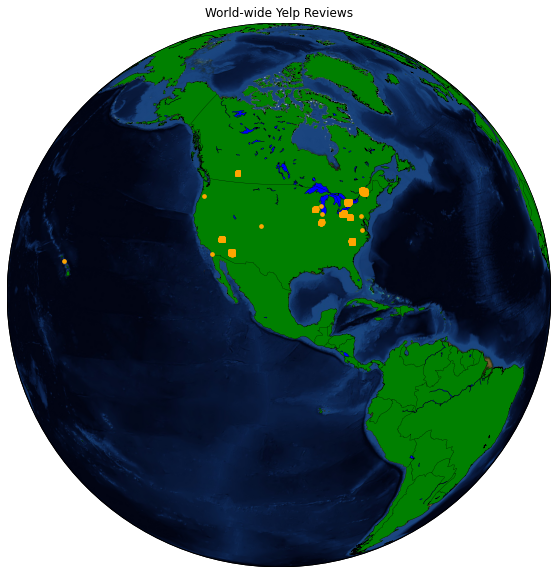

In [56]:
plt.figure(figsize=(20,10));
map = Basemap(projection='ortho',lat_0=25,lon_0=-100,resolution='l')
map.bluemarble()
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='blue')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='blue')
long_lat = map(df['longitude'].tolist(),df['latitude'].tolist())
map.scatter(long_lat[0], long_lat[1], s=3, c="orange", lw=3, alpha=1, zorder=5)
plt.title("World-wide Yelp Reviews")
plt.show();

In [57]:
print(df['longitude'].min())
print(df['longitude'].max())

-158.0255252123
-72.80655


We note from negative values for longitude that all the businesses in the yelp database are found in North America, in particular Canada and the United States. 

Lets take a closer look at Toronto

In [76]:
lon_min, lon_max = -80, -78.8
lat_min, lat_max = 43.2, 44.2

TOR = ((df["longitude"]>lon_min) &(df["longitude"]<lon_max)) &\
            ((df["latitude"]>lat_min) & (df["latitude"]<lat_max))

TOR_business = df[TOR].copy()

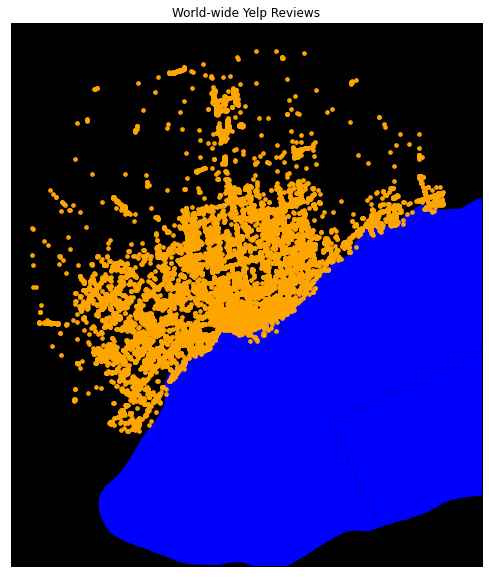

In [107]:
plt.figure(figsize=(20,10));
map = Basemap(projection='merc',llcrnrlat=lat_min,urcrnrlat=lat_max,llcrnrlon=lon_min,urcrnrlon=lon_max, resolution='f')
#map.bluemarble()
# country boundaries, fill continents.
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='black',lake_color='blue')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='blue')
TOR_ = map(TOR_business['longitude'].tolist(),TOR_business['latitude'].tolist())
map.scatter(TOR_[0], TOR_[1], s=3, c="orange", lw=3, alpha=1, zorder=5)
plt.title("World-wide Yelp Reviews")
plt.show();

In [87]:
TOR_business.sort_values(by='review_count', ascending=False).head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
65694,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,18 Duncan Street,Toronto,ON,M5H 3G8,43.647866,-79.388685,4.5,2758,1,"{'RestaurantsTableService': 'True', 'BikeParki...","Restaurants, Thai, Specialty Food, Food, Ethni...","{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:..."
183740,RtUvSWO_UZ8V3Wpj0n077w,KINKA IZAKAYA ORIGINAL,398 Church St,Toronto,ON,M5B 2A2,43.660430,-79.378927,4.0,1592,1,"{'RestaurantsAttire': 'u'casual'', 'BusinessPa...","Restaurants, Tapas/Small Plates, Japanese, Bar...","{'Monday': '17:0-0:0', 'Tuesday': '17:0-0:0', ..."
143305,aLcFhMe6DDJ430zelCpd2A,Khao San Road,11 Charlotte Street,Toronto,ON,M5V 2H5,43.646411,-79.393480,4.0,1542,1,"{'WiFi': 'u'no'', 'RestaurantsTakeOut': 'True'...","Thai, Restaurants","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."
133959,iGEvDk6hsizigmXhDKs2Vg,Seven Lives Tacos Y Mariscos,69 Kensington Avenue,Toronto,ON,M5T 2K2,43.654341,-79.400480,4.5,1285,1,"{'RestaurantsGoodForGroups': 'False', 'Alcohol...","Restaurants, Seafood, Mexican","{'Monday': '11:0-19:0', 'Tuesday': '11:0-19:0'..."
172038,N93EYZy9R0sdlEvubu94ig,Banh Mi Boys,392 Queen Street W,Toronto,ON,M5V 2A9,43.648827,-79.396970,4.5,1097,1,"{'Alcohol': 'u'none'', 'BikeParking': 'True', ...","Sandwiches, Restaurants, Food, Vietnamese, Asi...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [101]:
TOR_business['review_count'].describe()

count    36636.000000
mean        24.111830
std         54.647122
min          3.000000
25%          4.000000
50%          8.000000
75%         21.000000
max       2758.000000
Name: review_count, dtype: float64

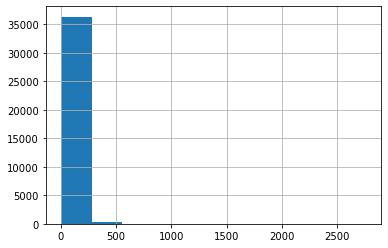

In [91]:
TOR_business['review_count'].hist();

The 'review_count' column is the number of reviews a business has received and we see in the histogram above that there are some business with thousands of reviews but 75% of the businesses in this dataset only have 21 reviews or less. 

The histogram below only shows business in Toronto will less than 100 reviews.

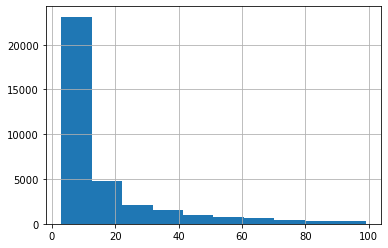

In [106]:
t_ = TOR_business[TOR_business['review_count']<100]['review_count'].hist()

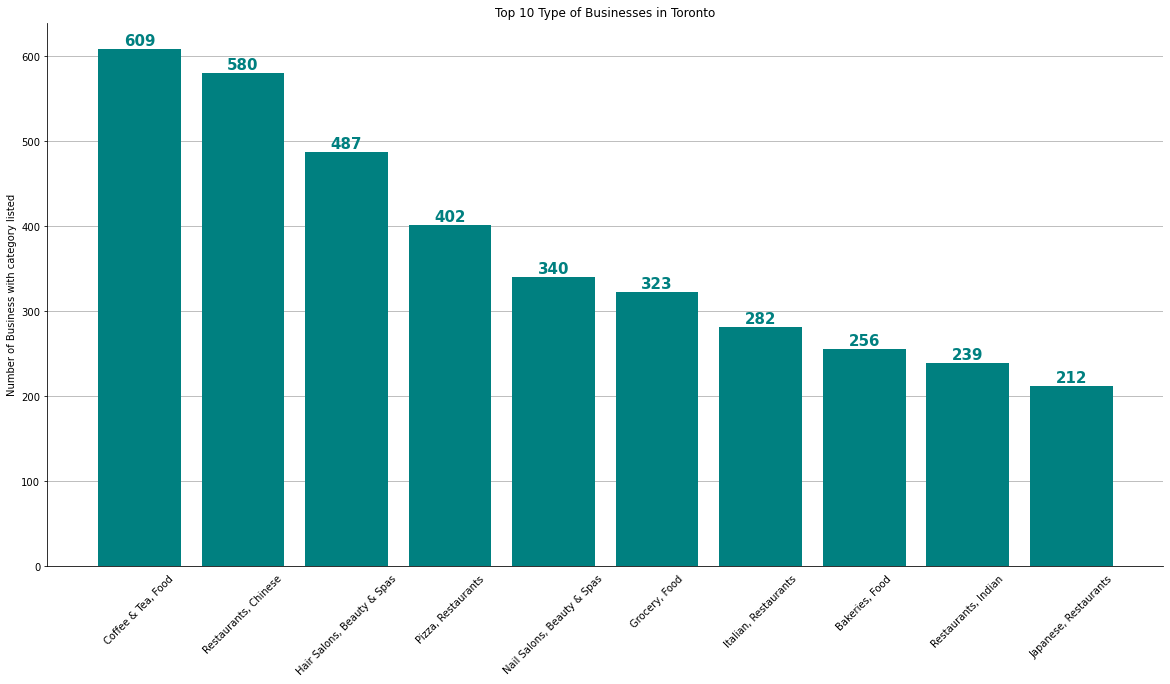

In [167]:
fig, ax = plt.subplots(figsize=(20,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=True)

ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.title('Top 10 Type of Businesses in Toronto')
plt.ylabel('Number of Business with category listed')
plt.xticks(np.arange(10), TOR_business['categories'].value_counts().head(10), rotation=45)

bars = ax.bar(
    x=np.arange(10),
    height=TOR_business['categories'].value_counts().head(10),
    color='teal',
    tick_label=TOR_business['categories'].value_counts().head(10).index
)

for bar in bars:
    plt.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 4,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='teal',
      weight='bold',
      size=15
    )

We can see in the figure above the top ten buisnesses (by count of each category) are counted twice. For example the number one most common business is 'Coffee & Tea, Food' and the second more common is 'Food, Coffee & Tea'. This needs to be addressed by combining the categories which have the text in their descriptions mixed up.

In [102]:
TOR_business['categories'].value_counts().head(10)

Coffee & Tea, Food            609
Restaurants, Chinese          580
Hair Salons, Beauty & Spas    487
Pizza, Restaurants            402
Nail Salons, Beauty & Spas    340
Grocery, Food                 323
Italian, Restaurants          282
Bakeries, Food                256
Restaurants, Indian           239
Japanese, Restaurants         212
Name: categories, dtype: int64

In [77]:
len(TOR_business['categories'].unique())

19661

In [79]:
TOR_business.loc[TOR_business['categories'] == 'Food, Coffee & Tea', 'categories'] = 'Coffee & Tea, Food'
TOR_business.loc[TOR_business['categories'] == 'Chinese, Restaurants', 'categories'] = 'Restaurants, Chinese'
TOR_business.loc[TOR_business['categories'] == 'Beauty & Spas, Hair Salons', 'categories'] = 'Hair Salons, Beauty & Spas'
TOR_business.loc[TOR_business['categories'] == 'Restaurants, Pizza', 'categories'] = 'Pizza, Restaurants'
TOR_business.loc[TOR_business['categories'] == 'Beauty & Spas, Nail Salons', 'categories'] = 'Nail Salons, Beauty & Spas'
TOR_business.loc[TOR_business['categories'] == 'Restaurants, Italian', 'categories'] = 'Italian, Restaurants'
TOR_business.loc[TOR_business['categories'] == 'Food, Grocery', 'categories'] = 'Grocery, Food'
TOR_business.loc[TOR_business['categories'] == 'Food, Bakeries', 'categories'] = 'Bakeries, Food'
TOR_business.loc[TOR_business['categories'] == 'Indian, Restaurants', 'categories'] = 'Restaurants, Indian'
TOR_business.loc[TOR_business['categories'] == 'Restaurants, Vietnamese', 'categories'] = 'Vietnamese, Restaurants'
TOR_business.loc[TOR_business['categories'] == 'Restaurants, Japanese', 'categories'] = 'Japanese, Restaurants'
TOR_business.loc[TOR_business['categories'] == 'Thai, Restaurants', 'categories'] = 'Restaurants, Thai'

In [101]:
TOR_business['categories'].value_counts().head(10)

Coffee & Tea, Food            609
Restaurants, Chinese          580
Hair Salons, Beauty & Spas    487
Pizza, Restaurants            402
Nail Salons, Beauty & Spas    340
Grocery, Food                 323
Italian, Restaurants          282
Bakeries, Food                256
Restaurants, Indian           239
Japanese, Restaurants         212
Name: categories, dtype: int64

---

Now we can plot the top 10 categories of businesses in Toronto:

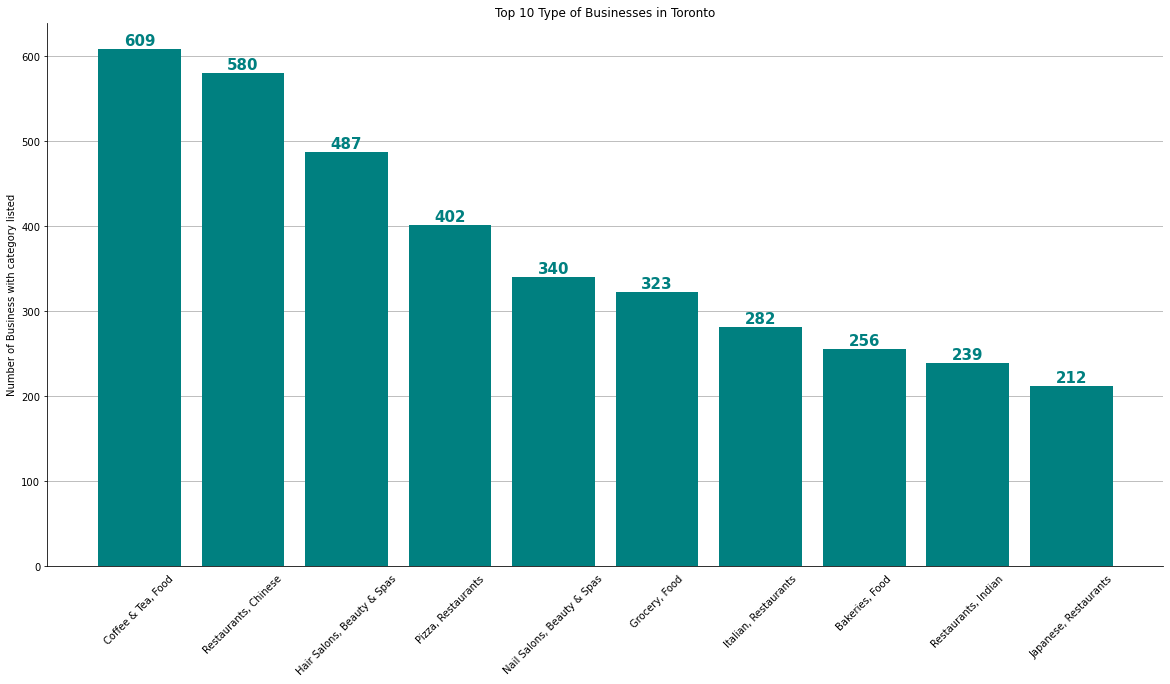

In [168]:
fig, ax = plt.subplots(figsize=(20,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=True)

ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.title('Top 10 Type of Businesses in Toronto')
plt.ylabel('Number of Business with category listed')
plt.xticks(np.arange(10), TOR_business['categories'].value_counts().head(10), rotation=45)

bars = ax.bar(
    x=np.arange(10),
    height=TOR_business['categories'].value_counts().head(10),
    color='teal',
    tick_label=TOR_business['categories'].value_counts().head(10).index
)

for bar in bars:
    plt.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 4,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='teal',
      weight='bold',
      size=15
    )

In [248]:
Tor_catlist = TOR_business['categories'].tolist()

In [251]:
from collections import Counter
c = Counter()
for n in Tor_catlist:
    if n is not None:
        cat_list = n.split(', ')
        for cat in cat_list:
            c[cat] += 1
    else:
        c['N/A'] += 1

In [252]:
c.most_common(10)

[('Restaurants', 16227),
 ('Food', 7979),
 ('Shopping', 5596),
 ('Beauty & Spas', 3610),
 ('Nightlife', 2743),
 ('Coffee & Tea', 2456),
 ('Bars', 2452),
 ('Health & Medical', 1891),
 ('Chinese', 1817),
 ('Event Planning & Services', 1795)]

In [255]:
TORcat = pd.DataFrame.from_dict(c, orient='index')

In [282]:
TORcat.sort_values(by=0,ascending=False).head(10)

,0
Restaurants,16227
Food,7979
Shopping,5596
Beauty & Spas,3610
Nightlife,2743
Coffee & Tea,2456
Bars,2452
Health & Medical,1891
Chinese,1817
Event Planning & Services,1795


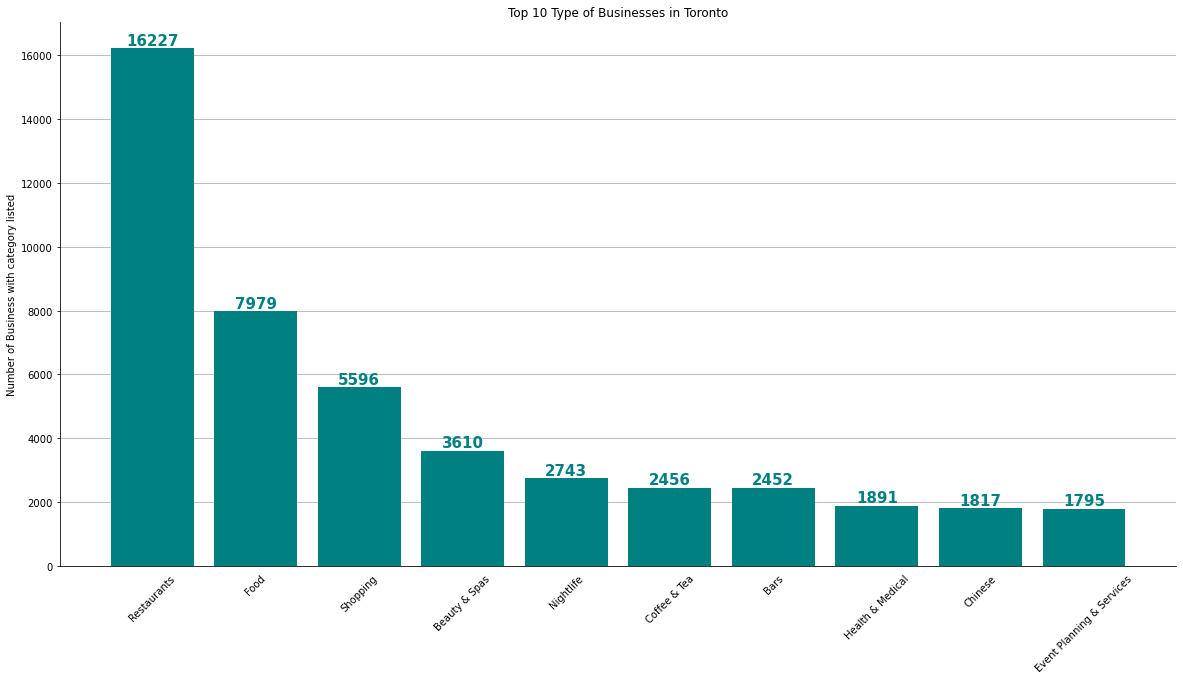

In [300]:
tmp_ = TORcat.sort_values(by=0,ascending=False).head(10)

fig, ax = plt.subplots(figsize=(20,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=True)

ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.xaxis.grid(False)
plt.title('Top 10 Type of Businesses in Toronto')
plt.ylabel('Number of Business with category listed')
plt.xticks(np.arange(10), tmp_.value_counts(), rotation=45)

bars = ax.bar(
    x=np.arange(10),
    height=tmp_[0].values,
    color='teal',
    tick_label=tmp_.index
)

for bar in bars:
    plt.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 100,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color='teal',
      weight='bold',
      size=15
    )

In [147]:
top_ten_list = TOR_business['categories'].value_counts().head(10).index.tolist()
TOR_business.groupby('categories').agg(['mean']).loc[top_ten_list,:].sort_values(by=('stars','mean'),ascending=False)['stars']

,mean
categories,
"Bakeries, Food",3.705078
"Italian, Restaurants",3.489362
"Hair Salons, Beauty & Spas",3.434292
"Coffee & Tea, Food",3.428571
"Restaurants, Indian",3.424686
"Japanese, Restaurants",3.318396
"Restaurants, Chinese",3.192241
"Pizza, Restaurants",3.136816
"Grocery, Food",3.082043


The top ten businesses, by number of a businesses in a unique category, have their average rating shown above in descending order.

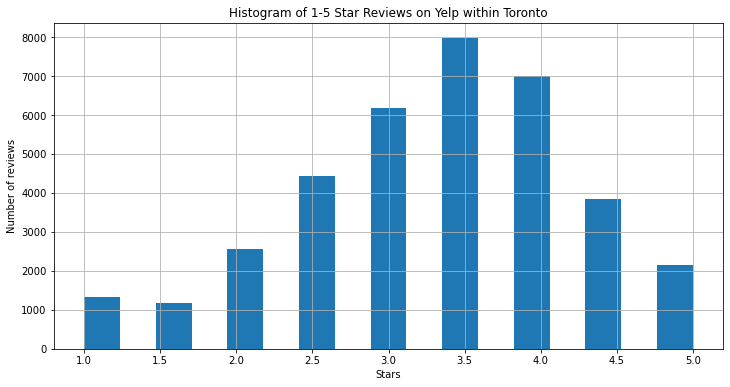

In [183]:
plt.figure(figsize=(12,6))
TOR_business['stars'].hist(bins=17)
plt.title('Histogram of 1-5 Star Reviews on Yelp within Toronto')
plt.xlabel('Stars')
plt.ylabel('Number of reviews');